# [Implementing Neural Networks with Numpy](https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65)

## [Part 4: Neural Networks from Scratch](https://github.com/OmarAflak/Medium-Python-Neural-Network)  

In this post we will go through the mathematics of machine learning and code from scratch, in Python, a small library to build neural networks with a variety of layers (Fully Connected, Convolutional, etc.). Eventually, we will be able to create networks in a modular fashion:

#### Layer by Layer

We need to keep in mind the big picture here :

+ We feed input data into the neural network.
+ The data flows from layer to layer until we have the output.
+ Once we have the output, we can calculate the error which is a scalar.
+ Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.
    
We iterate through that process.

The most important step is the 4th. We want to be able to have as many layers as we want, and of any type. But if we modify/add/remove one layer from the network, the output of the network is going to change, which is going to change the error, which is going to change the derivative of the error with respect to the parameters. We need to be able to compute the derivatives regardless of the network architecture, regardless of the activation functions, regardless of the loss we use.

In order to achieve that, we must implement each layer separately.

### What every layer should implement

Every layer that we might create (fully connected, convolutional, maxpooling, dropout, etc.) have at least 2 things in common: input and output data.

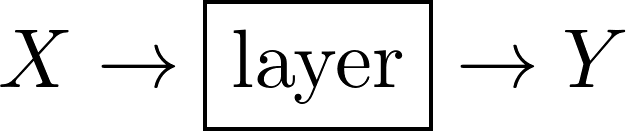

In [2]:
from IPython.display import display, Image
Image(filename='./Images/1nn.png')

### Forward propagation

We can already emphasize one important point which is: the output of one layer is the input of the next one.

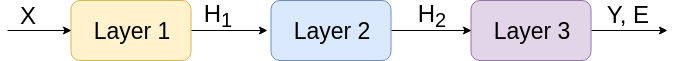

In [3]:
Image(filename='./Images/2nn.png')

This is called forward propagation. Essentially, we give the input data to the first layer, then the output of every layer becomes the input of the next layer until we reach the end of the network. By comparing the result of the network (Y) with the desired output (let’s say Y*), we can calculate en error E. The goal is to minimize that error by changing the parameters in the network. That is backward propagation (backpropagation).

### Gradient Descent

This is a quick reminder, if you need to learn more about gradient descent there are tons of resources on the internet.

Basically, we want to change some parameter in the network (call it w) so that the total error E decreases. There is a clever way to do it (not randomly) which is the following :

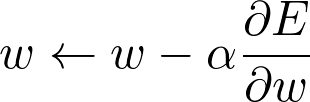

In [4]:
Image(filename='./Images/3nn.png')

Where α is a parameter in the range [0,1] that we set and that is called the learning rate. Anyway, the important thing here is ∂E/∂w (the derivative of E with respect to w). We need to be able to find the value of that expression for any parameter of the network regardless of its architecture.
Backward propagation

Suppose that we give a layer the derivative of the error with respect to its output (∂E/∂Y), then it must be able to provide the derivative of the error with respect to its input (∂E/∂X).

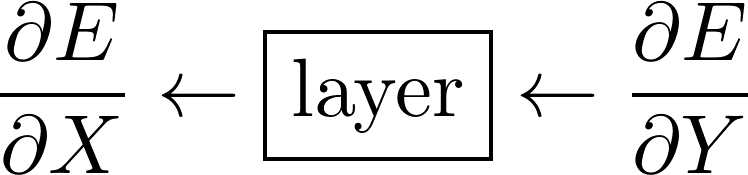

In [5]:
Image(filename='./Images/4nn.png')

Remember that E is a scalar (a number) and X and Y are matrices.

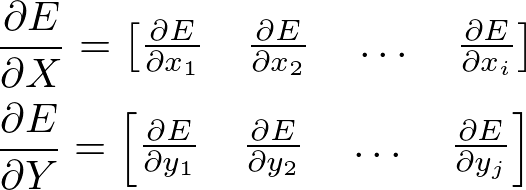

In [7]:
Image(filename='./Images/5nn.png')

Let’s forget about ∂E/∂X for now. The trick here, is that if we have access to ∂E/∂Y we can very easily calculate ∂E/∂W (if the layer has any trainable parameters) without knowing anything about the network architecture! 
We simply use the chain rule :

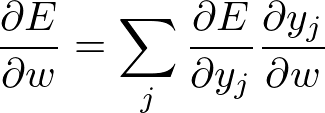

In [9]:
Image(filename='./Images/6nn.png')

The unknown is $∂y_j/∂w$ which totally depends on how the layer is computing its output. So if every layer have access to ∂E/∂Y, where Y is its own output, then we can update our parameters!

### But why ∂E/∂X ?

Don’t forget, the output of one layer is the input of the next layer. Which means ∂E/∂X for one layer is ∂E/∂Y for the previous layer!  

That’s it ! It’s just a clever way to propagate the error ! Again, we can use the chain rule :

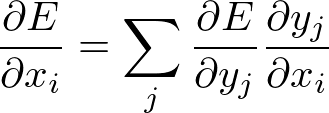

In [10]:
Image(filename='./Images/7nn.png')

This is very important, it’s the key to understand backpropagation ! After that, we’ll be able to code a Deep Convolutional Neural Network from scratch in no time !
Diagram to understand backpropagation

This is what I described earlier. Layer 3 is going to update its parameters using ∂E/∂Y, and is then going to pass ∂E/∂H2 to the previous layer, which is its own “∂E/∂Y”. Layer 2 is then going to do the same, and so on and so forth.

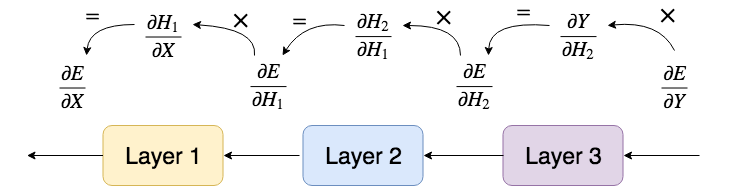

In [11]:
Image(filename='./Images/8nn.png')

This may seem abstract here, but it will get very clear when we will apply this to a specific type of layer. Speaking of abstract, now is a good time to write our first python class.

### Abstract Base Class : Layer

The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [12]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

As you can see there is an extra parameter in backward_propagation that I didn’t mention, it is the learning_rate. This parameter should be something like an update policy, or an optimizer as they call it in Keras, but for the sake of simplicity we’re simply going to pass a learning rate and update our parameters using gradient descent.

### Fully Connected Layer

Now let's define and implement the first type of layer: fully connected layer or FC layer. FC layers are the most basic layers as every input neurons are connected to every output neurons.

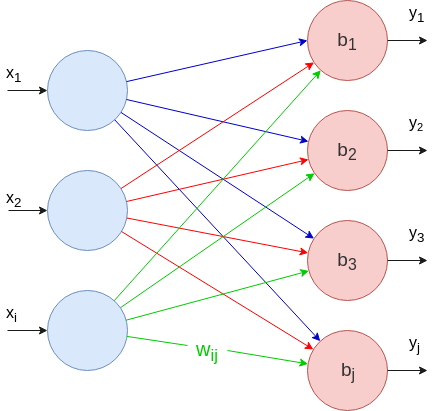

In [13]:
Image(filename='./Images/9nn.png')

### Forward Propagation

The value of each output neuron can be calculated as the following :

With matrices, we can compute this formula for every output neuron in one shot using a dot product :